# Using Machine Learning to Predict Handwritten Digits
For our final project, we are creating a neural network model to predict the results of handwritten digits using a combination of training data by MNIST and our own class's dataset.

To accomplish this task, we have broken down the problem into smaller steps in order to understand how to achieve our goal. Therefore some of the following code blocks may be messy as we refine our final results.

## Step 1: Convert our Class Data
Before we begin, we decided that we needed to convert our 28 by 28 pixel images into a machine readable format. This will help us later when it's time to actually train our model.

In [234]:
# Import necessary packages
import os
import struct
import numpy as np
from PIL import Image
import torch

# Import helpers
import matplotlib.pyplot as plt

# Function to convert image to numpy array (grayscale or RGB)
def image_to_array(image_path):
    image = Image.open(image_path).convert('L')  # Convert to grayscale (L mode)
    return image

#write to idx3 for images and idx1 for labels
def write_idx(images, labels, output_image_file, output_label_file):
    # Write the images in IDX3 format
    with open(output_image_file, 'wb') as f:
        f.write(struct.pack(">I", 2051))  # Magic number for images (2051)
        
        # Number of images, rows, cols
        f.write(struct.pack(">I", len(images)))  # Number of images
        f.write(struct.pack(">I", 28))  # Rows and columns (28X28 image)
        f.write(struct.pack(">I", 28))
        
        for image in images:
            # Write each image as a flat byte array
            f.write(image.tobytes())
            
    # Write the labels in IDX3 format
    with open(output_label_file, 'wb') as f:
        # Magic number for labels
        f.write(struct.pack(">I", 2049))  # Magic number for labels (2049)
        
        # Number of labels
        f.write(struct.pack(">I", len(labels)))  # Number of labels
        
        for label in labels:
            # Write the label as a single byte
            f.write(struct.pack("B", label))

# Run our conversions for each image file
def convert(input_folder, output_image_file, output_label_file):
    images = []
    labels = []
    
    for filename in os.listdir(input_folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):
            # get label from Group5.Digits.<label char>_##.png
            label = filename[14]
            
            # opena nd convert to greyscale
            image = image_to_array(os.path.join(input_folder, filename))
            
            # Add image as array and add the label
            images.append(np.array(image))
            labels.append(int(label))
            
    # Convert to numpy array
    images = np.array(images)
    labels = np.array(labels)
    print(images.shape)
     # Flatten images
    images = images.reshape(len(images), -1)
    
    # Write our new files for later usage
    write_idx(images, labels, output_image_file, output_label_file)

# File Paths
input_folder = "./image_files/digits/"
output_folder = "./train_data/"
output_image_file = os.path.join(output_folder, "Group5.Digits.Images.idx3-ubyte")
output_label_file = os.path.join(output_folder, "Group5.Digits.Labels.idx1-ubyte")

# Convert to IDX format
convert(input_folder, output_image_file, output_label_file)

(30, 28, 28)


## Step 2 (optional): Visualize the Data
Our data should be successfully converted, however, just to be sure that everything works as intended, we'll visualize the data from its IDX3 and IBX1 image and label formats.

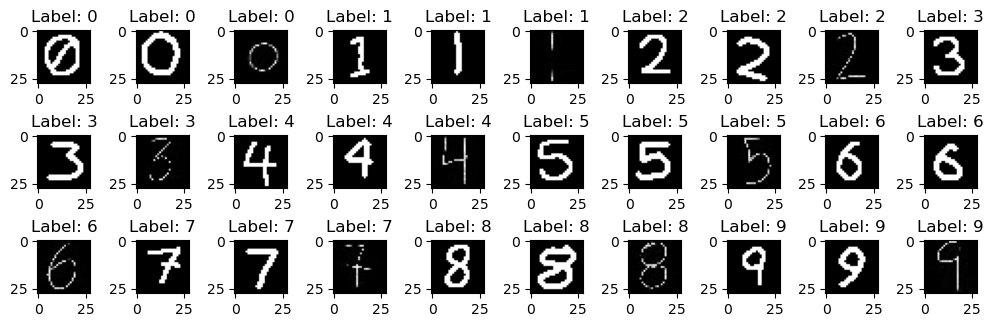

In [235]:
# Open the new idx3 file for images
def read_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
    return images

# Open the new idx1 file for labels
def read_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

# Call our functions and store our images and labels
images = read_images('./train_data/Group5.Digits.Images.idx3-ubyte')
labels = read_labels('./train_data/Group5.Digits.Labels.idx1-ubyte')

# Create variables for display
num_images = len(images)
num_cols = 10
num_rows = (num_images + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 1.1))
axes = axes.flatten()  

# Print our plot of images and labels
for i in range(num_images):
    ax = axes[i]  
    image = images[i].reshape(28, 28)  
    ax.imshow(image, cmap='gray')  
    ax.set_title(f"Label: {labels[i]}")  

plt.tight_layout()
plt.show()

# Creating the Neural Net
Now that our custom data is correctly formatted, we can begin to design our neural net.

## Step 1: Load the Data
For our testing purposes, we decided to follow the provided skeleton and design it based around the MNIST dataset. In order to do this, we need to define a normal transform to apply the newly downloaded data to.

The 'transform' combines multiple transforms into a single callable transform, contianing each image as a tensor with scaled pixels. This assures that each loaded image is the same size and format in order for our neural net to train correctly.

Then we download and load our MNIST dataset into a 'Data Loader' which will handle the batching, shuffling, and loading of our new data.

In [217]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print (trainloader)

## Step 2: Creating the Model
Now that we have our data loaded, we can move on to define our model. Once again, we'll begin by following the pre-defined skeleton without any major tweaking. 

In [218]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128), # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10), # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 0.0004,  0.0004,  0.0004,  ...,  0.0004,  0.0004,  0.0004],
        [ 0.0038,  0.0038,  0.0038,  ...,  0.0038,  0.0038,  0.0038],
        [ 0.0036,  0.0036,  0.0036,  ...,  0.0036,  0.0036,  0.0036],
        ...,
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        [ 0.0017,  0.0017,  0.0017,  ...,  0.0017,  0.0017,  0.0017],
        [ 0.0007,  0.0007,  0.0007,  ...,  0.0007,  0.0007,  0.0007]])


## Step 3: Training our Neural Net
Now that our model is ready, we can finally train it on the MNIST dataset that we previously loaded.

We first define an optimizer for our training. In this case we're using the Stochastic Gradient Descent algorithm, which updates the model's parameters using the gradients that are computed during backpropagation and our defined learning rate.

Then we choose the number of training loops (or epochs) to run the model through, and create an array for storing our loss data.

Finally we run the actual training loop! 
For each iteration over an epoch, we set our current loss to 0 and define an array to store each loss as we traverse our image batch.

## Batch Looping
There are several steps that happen within our batch loop as we traverse over our images.

#### Step 1: Flatten the image
The model expects the input images to be one-dimensional vectors or 1D tensors, so the images are flattened into vectors of the size 784 (28 px * 28 px).

#### Step 2: Zero the gradients
Before we can backpropagate, we need to clear any existing gradients from the previous batch because the gradients are accumulated by default within PyTorch.

#### Step 3: Forward Pass
The forward pass sends the 1D images through the model, which then produces a prediction which we store as 'output'.

#### Step 4: Calculate Loss
The loss is calculated by comparing the model's output predictions with the true labels of the images using the loss function 'criterion'. This measures how far the predictions are from the actual labels, which the optimizer will try to minimize during further training.

#### Step 5: Backwards Pass
This computes the gradient of the loss with respect to each parameter in the model by using backpropagation. These gradients are then used by the optimizer to update the model's parameters.

#### Step 6: Optimizer Step
After the gradients are computed, we 'step()' the optimizer to update the model's parameters using the computed gradients and learning rate.

#### Step 7: Loss Tracking
The loss for the current batch is added to 'running_loss', and the loss for each batch is saved in 'epoch_losses'. These are used to print our current epoch loss and create a graph based on each batch's loss.

In [221]:

optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")

Epoch 1/5, Loss: 0.9808
Epoch 2/5, Loss: 0.3794
Epoch 3/5, Loss: 0.3234
Epoch 4/5, Loss: 0.2926
Epoch 5/5, Loss: 0.2687
Training complete!


## Graphing our Loss
We can visualize our loss calculated during our training by mapping it to a graph. As you can see, we begin with a high loss which gradually lowers as the model continues its training.

Length of trainloader:938


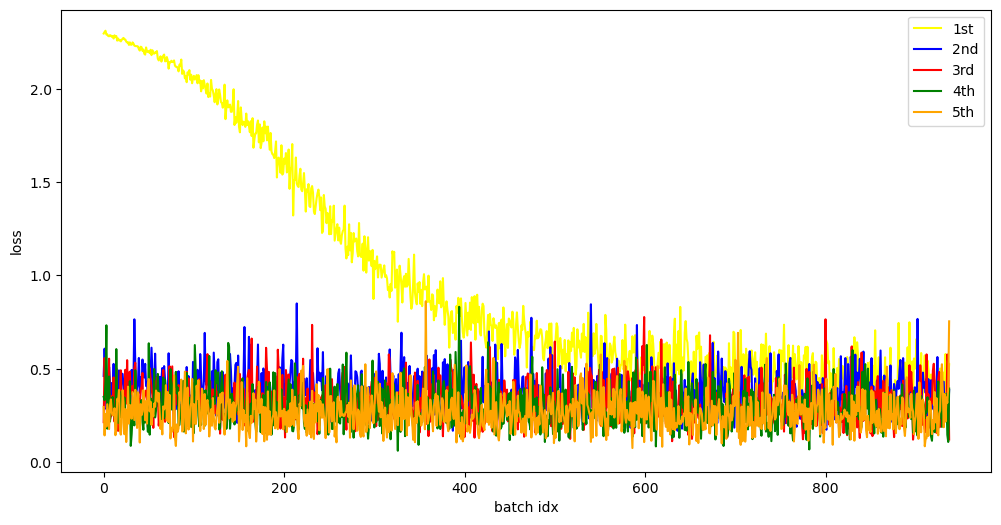

In [222]:
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

# Put it all together!
This is the combination of all the above steps, and a good representation of our final product. 
Here, we've modified the model a bit to achieve some higher accuracy with its predictions.

We changed the model's Activation Function to ELU from ReLU. ELU is a more complex activation function that outputs zero for negative inputs, but smoothly decays to negative values instead of staying at zero. This should prevent the vanishing gradient problem by allowing negative values, which could potentially improve our training performance. Ultimately, this may be unnecessary, but was something fun to test.

Then, we chose to normalize the batches and use a the dropout technique. Normalizing batches can potentially speed up and stabalize the training, as can Dropouts, which prevents the model from overfitting by forcing it to rely on multiple paths of the network rather than a few neurons.

## Potential for Higher Accuracy
Adding additional hidden layers and more iterations (epochs) would most certainly result in a higher accuracy for our model, but we were unsure whether or not this was necessarily allowed. Therefore, we left those as default and decided instead to change our optimizer.

#### SGD vs Adam
We changed the optimizer from SGD (Stochastic Gradient Descent) to Adam (Adaptive Moment Estimation), mostly out of experimentation choices.
Adam is an adaptive optimization algorithm that computes learning rates for each parameter based on estimates of the first and second moments of the gradient (AKA: The mean and uncentered variance of the gradents). By adapting its learning rates based on gradient history, Adam can accelerate learning and improve convergence with sparce or noisy data. This could help us later, as our Class Dataset is relatively small in comparison to the MNIST dataset.

Epoch 1/5, Loss: 0.3347
Epoch 2/5, Loss: 0.1975
Epoch 3/5, Loss: 0.1633
Epoch 4/5, Loss: 0.1459
Epoch 5/5, Loss: 0.1301
Training complete!
Length of trainloader:938


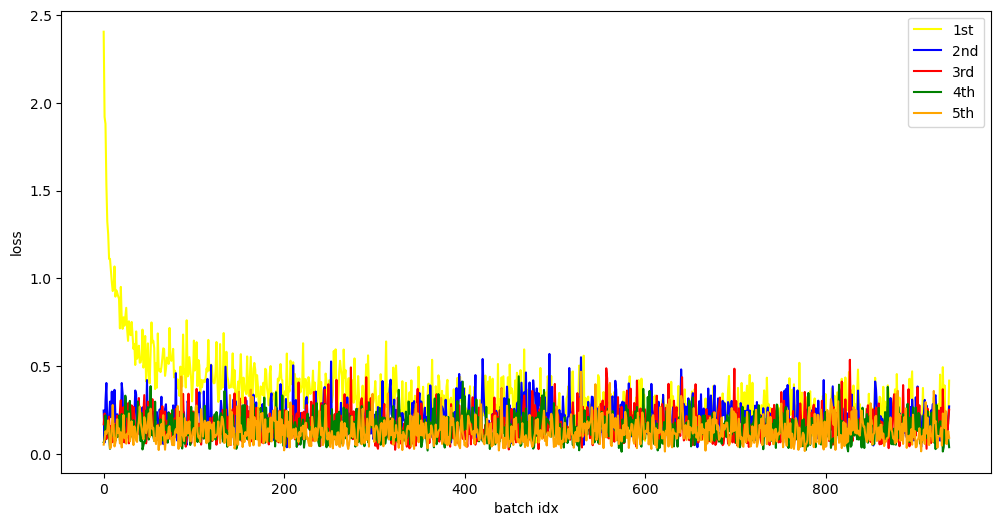

In [223]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
%matplotlib inline

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


## Loss and Autograd model
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),   # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ELU(),              # Activation function
                      nn.BatchNorm1d(128),   # Normalize our batch for stability
                      nn.Dropout(0.2),       # Prevent overfitting
                      nn.Linear(128, 64),
                      nn.ELU(),
                      nn.BatchNorm1d(64),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),     # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

# Check if we can run this on a GPU, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Loss function
criterion = nn.NLLLoss()


## Training Loop
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in trainloader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")
    
print("Training complete!")



## Print the visuals
x = np.arange(len(trainloader))

print (f"Length of trainloader:{len(trainloader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

# Prediction testing with MNIST
Finally we can move on to prediction testing!
The following code is relatively simple. It chooses the next image from our loader and runs our model in evaluation mode. We then feed the model the image and display the results. 

You can re-run this code block to check another image.

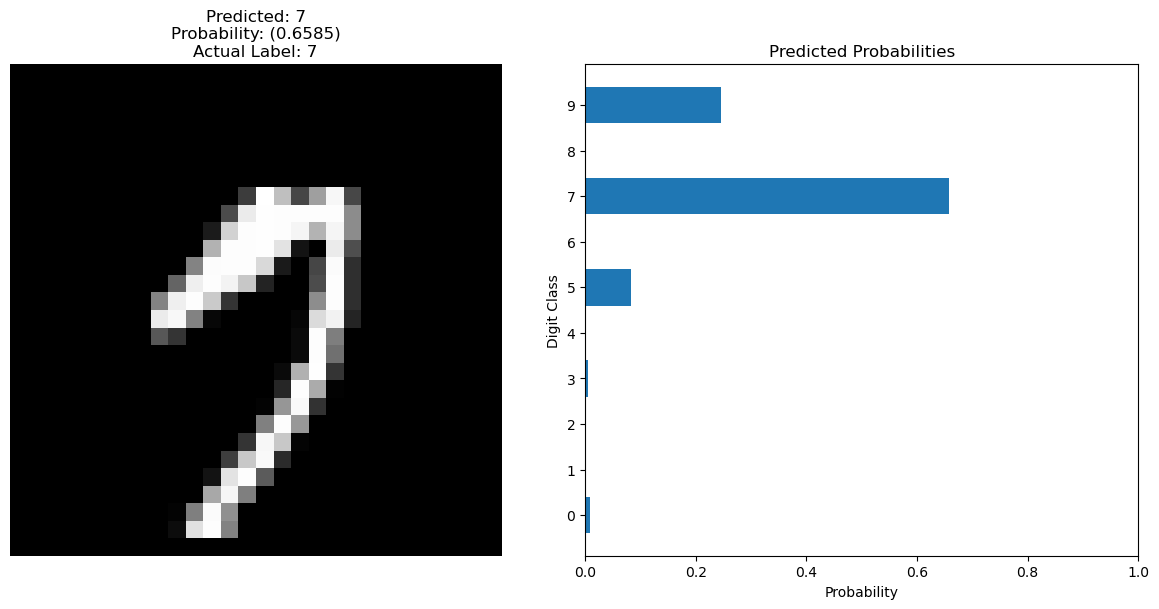

In [224]:
%matplotlib inline
import helper

# we are just using an image from trainloader, in the future we'll use frorm testloader
images, labels = next(iter(trainloader))

img = images[33].view(1, 784)

model.eval()

# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()


# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
label = class_idx.item()

# Plot the image and probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted: {label}\nProbability: ({prob.item():.4f})\nActual Label: {labels[33].item()}")  # Display predicted and actual label
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlim(0, 1)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

## Convert the 580 Class Data
Now that we can successfully predict the MNIST data, we need to do the same for our class data.
After downloading the data, we'll use a similar code block as earlier to convert it to a machine readable format. We also will spit out an error if any images are not formatted or sized correctly before reformatting and resizing them.

In [225]:
%matplotlib inline

# File Paths
input_folder = "./digits/"
output_folder = "./test_data/"
output_image_file = os.path.join(output_folder, "Class.Digits.Images.idx3-ubyte")
output_label_file = os.path.join(output_folder, "Class.Digits.Labels.idx1-ubyte")

images = []
labels = []

for filename in os.listdir(input_folder):
    if filename.endswith((".png", ".jpg", ".jpeg")):
        # get label from Group5.Digits.<label char>_##.png
        label = filename[0]
        
        # opena nd convert to greyscale
        image = Image.open(os.path.join(input_folder, filename)).convert('L')
        if image.size != (28, 28):
            print(f"Image {filename} is not 28x28, it has shape {image.size}")
            print(f"Group {filename[2]}, shame on you!")
            image = image.resize((28, 28))
        image = np.array(image)
        # Add image as array and add the label
        images.append(image)
        labels.append(int(label))

# Convert to numpy array
images = np.array(images)
labels = np.array(labels)

# Flatten images
images = images.reshape(len(images), -1)

# Write our new files for later usage
write_idx(images, labels, output_image_file, output_label_file)

Image 0-3-4.png is not 28x28, it has shape (28, 26)
Group 3, shame on you!
Image 2-3-4.png is not 28x28, it has shape (28, 26)
Group 3, shame on you!
Image 5-3-4.png is not 28x28, it has shape (29, 28)
Group 3, shame on you!
Image 6-3-4.png is not 28x28, it has shape (29, 28)
Group 3, shame on you!
Image 8-3-4.png is not 28x28, it has shape (29, 28)
Group 3, shame on you!


# Prediction Testing with the 580 Class Dataset
Now we use our model to predict images based on the Class's dataset. Remember, this is still the model that was trained only on the MNIST images. This was done mainly as a way to check if we were accomplishing the task correctly.

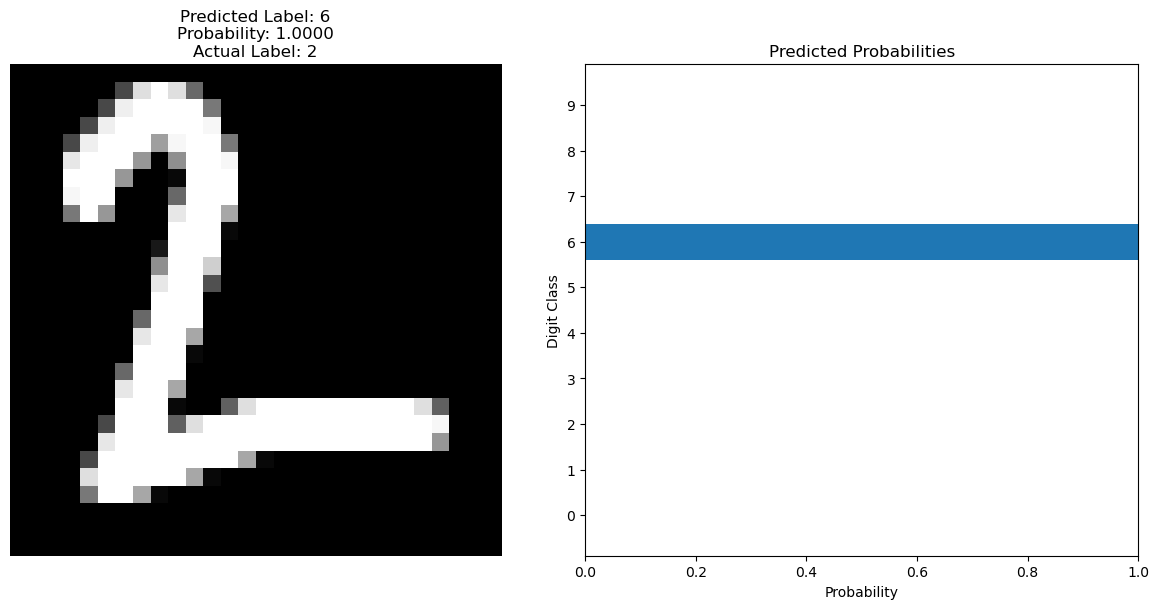

In [226]:
%matplotlib inline

from torch.utils.data import TensorDataset, DataLoader

model.eval()

# Using the numpy arrays fromn the previous block,
# Convert the images and labels into tensors
if isinstance(images, torch.Tensor):
    images_tensor = images.clone().detach().float()
else:
    images_tensor = torch.tensor(images, dtype=torch.float32)
    
if isinstance(labels, torch.Tensor):
    labels_tensor = labels.clone().detach().long()
else:
    labels_tensor = torch.tensor(labels, dtype=torch.long)


# Create a dataset
dataset = TensorDataset(images_tensor, labels_tensor)

# Create the dataloader
testLoader = DataLoader(dataset, batch_size=64, shuffle=True)


# we are just using an image from trainloader, in the future we'll use frorm testloader
images, labels = next(iter(testLoader))

img_idx = min(4, len(images) - 1)  # Use a valid index
img = images[img_idx].view(1, 784)  # Clamp the array within our index

# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()

# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
label = class_idx.item()

# Plot the image and the probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted Label: {label}\nProbability: {prob.item():.4f}\nActual Label: {labels[img_idx].item()}")
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlim(0, 1)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

# Train on the Class Dataset
Now that we've successfully trained a tested the predictions of a model on MNIST, we wanted to make sure we could accomplish the same task with a model trained only on the Class's data.
Below is just a copy of the previous model, but instead of training it on the MNIST dataset, we'll train it on our loaded Class dataset and check how well it can predict digits.

As you can tell by the graph, it's not quite as dense of a dataset, so the downward trend it losses is hard to track, but trust us it's there!

Epoch 1/5, Loss: 1.7481
Epoch 2/5, Loss: 1.0399
Epoch 3/5, Loss: 0.8245
Epoch 4/5, Loss: 0.6329
Epoch 5/5, Loss: 0.5113
Training complete!

Length of loader: 63


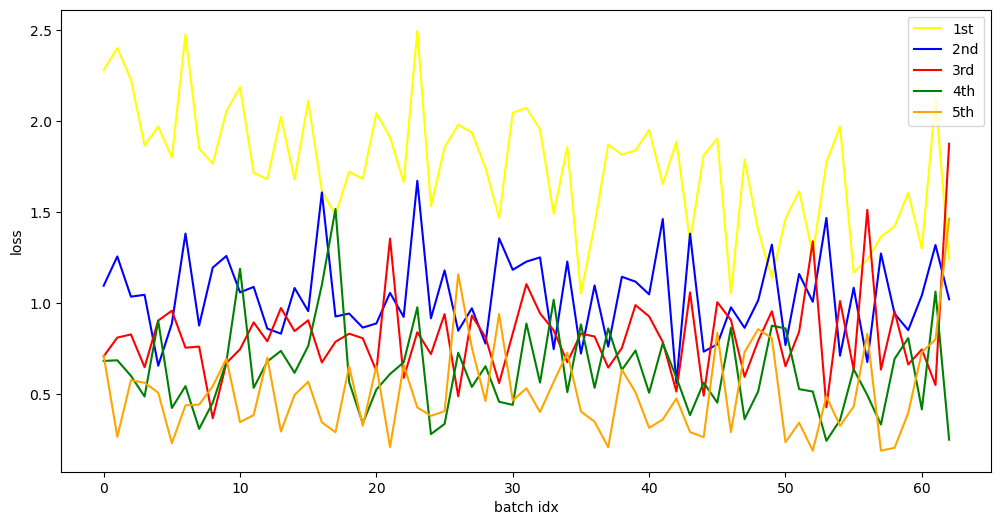

In [227]:
%matplotlib inline

# Training Loop for custom data

bsize = 8

# Flatten images during data loading
images_tensor = images_tensor.view(images_tensor.size(0), -1)  # Flatten to (batch_size, 784)

dataset = TensorDataset(images_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=bsize, shuffle=True)

## Loss and Autograd model
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),   # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ELU(),              # Activation function
                      nn.BatchNorm1d(128),   # Normalize our batch for stability
                      nn.Dropout(0.2),       # Prevent overfitting
                      nn.Linear(128, 64),
                      nn.ELU(),
                      nn.BatchNorm1d(64),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),     # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

# Check if we can run this on a GPU, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Loss function
criterion = nn.NLLLoss()
epochs = 5 # Number of training cycles
losses = []

## Training Loop
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in loader:
        
        # Zero out the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(loader):.4f}")
    
print("Training complete!")



## Print the visuals
x = np.arange(len(loader))

print (f"\nLength of loader: {len(loader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

By once again running our previously defined Class dataset prediction, we can check and see how well this model predicts compared to the MNIST trained model. 

Surprisingly, it is relatively accurate!

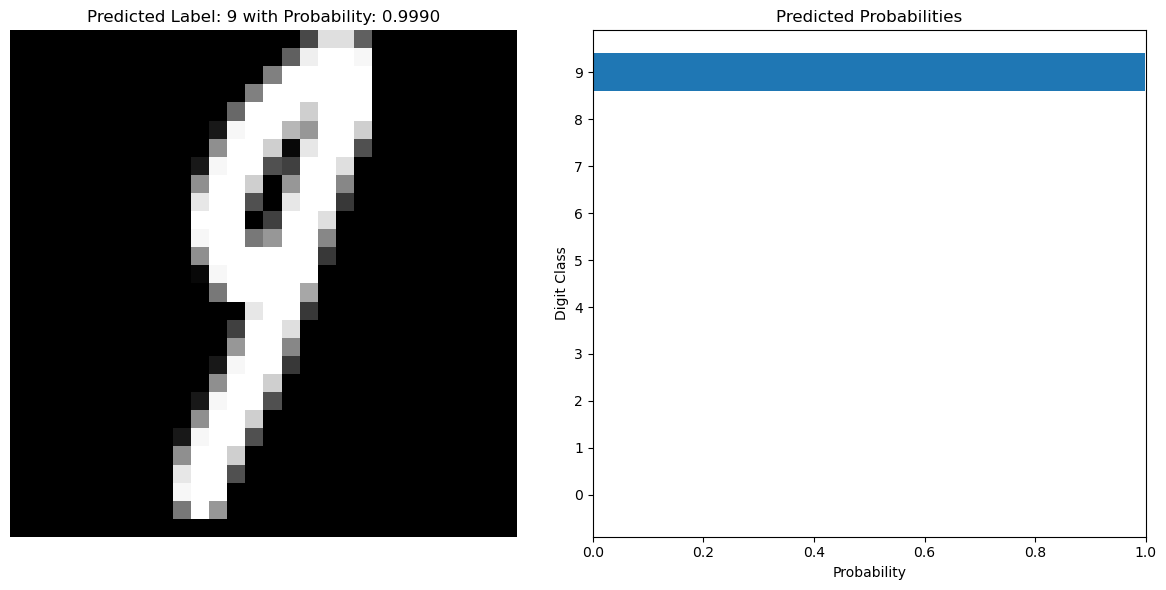

In [278]:
%matplotlib inline

model.eval()

# Using the numpy arrays fromn the previous block,
# Convert the images and labels into tensors
if isinstance(images, torch.Tensor):
    images_tensor = images.clone().detach().float()
else:
    images_tensor = torch.tensor(images, dtype=torch.float32)
    
if isinstance(labels, torch.Tensor):
    labels_tensor = labels.clone().detach().long()
else:
    labels_tensor = torch.tensor(labels, dtype=torch.long)


# Create a dataset
dataset = TensorDataset(images_tensor, labels_tensor)

# Create the dataloader
testLoader = DataLoader(dataset, batch_size=64, shuffle=True)



# we are just using an image from trainloader, in the future we'll use frorm testloader
images, labels = next(iter(testLoader))

img_idx = min(4, images.size(0) - 1)  # Use a valid index within the batch
img = images[img_idx].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()

# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
label = class_idx.item()

# Plot the image and the probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted Label: {label} with Probability: {prob.item():.4f}")
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlim(0, 1)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

# Predicting with MNIST
Now we'll try to predict MNIST data. As we can see, it's pretty rough. Because this model was trained only on a small pool of our custom Class data, it has a hard time predicting numbers from the large MNIST dataset.

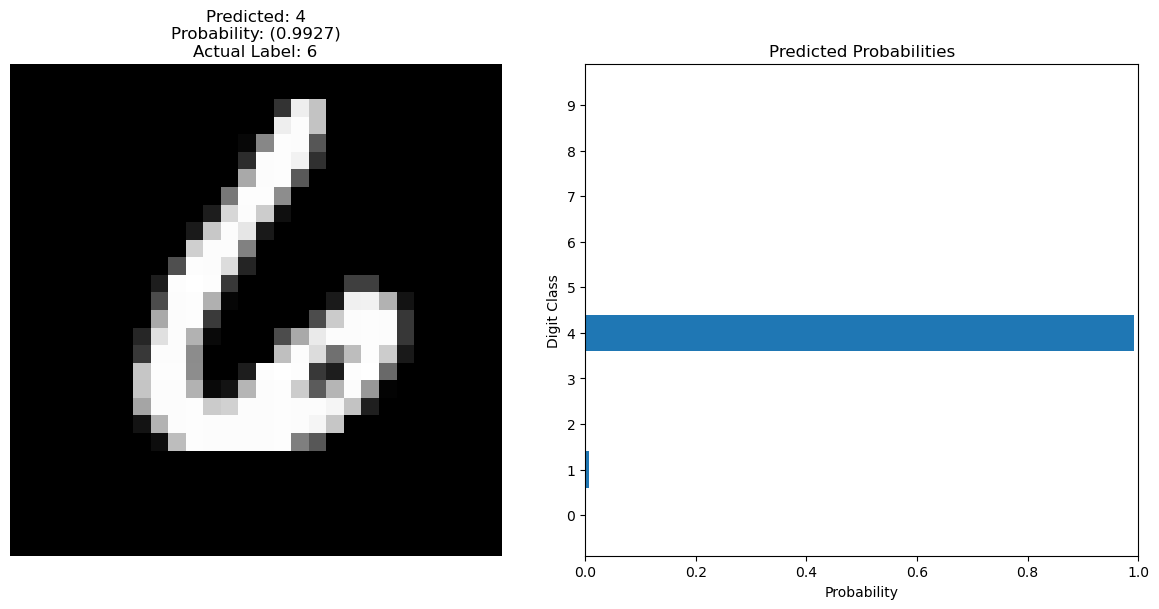

In [297]:
%matplotlib inline
import helper

# we are just using an image from trainloader, in the future we'll use frorm testloader
images, labels = next(iter(trainloader))

img = images[33].view(1, 784)

model.eval()

# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()


# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
label = class_idx.item()

# Plot the image and probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted: {label}\nProbability: ({prob.item():.4f})\nActual Label: {labels[33].item()}")  # Display predicted and actual label
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlim(0, 1)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

# Training our Final Model
Our finalized neural net model will train on the combination of MNIST data and our Class's data by running two seperate training loops.

Epoch 1/5, Loss: 0.3374
Epoch 2/5, Loss: 0.1940
Epoch 3/5, Loss: 0.1543
Epoch 4/5, Loss: 0.1445
Epoch 5/5, Loss: 0.1329
Training complete!
Length of MNIST_loader:938


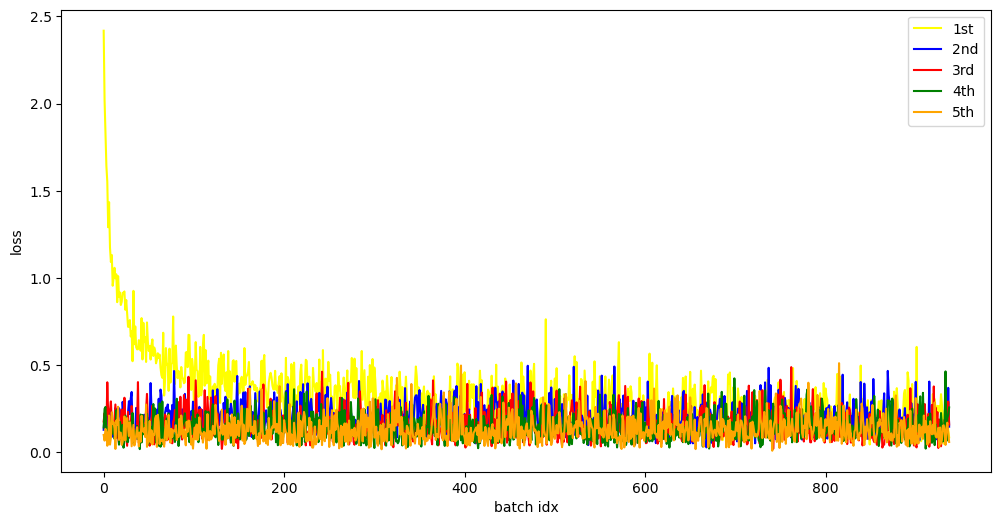

In [230]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
%matplotlib inline

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
mnist_trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
mnist_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

## Loss and Autograd model
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),   # Flattened MNIST image sizes (28x28) & Linear layer maps
                      nn.ELU(),              # Activation function
                      nn.BatchNorm1d(128),   # Normalize our batch for stability
                      nn.Dropout(0.2),       # Prevent overfitting
                      nn.Linear(128, 64),
                      nn.ELU(),
                      nn.BatchNorm1d(64),
                      nn.Dropout(0.2),
                      nn.Linear(64, 10),     # 10 output layers for each digit
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

# Check if we can run this on a GPU, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


## Loss function
criterion = nn.NLLLoss()

# Training on the MNIST Data
## Training Loop
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5 # Number of training cycles
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in mnist_loader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(mnist_loader):.4f}")
    
print("Training complete!")



## Print the visuals
x = np.arange(len(mnist_loader))

print (f"Length of MNIST_loader:{len(mnist_loader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

Now let's read and import our custom data...

In [299]:
%matplotlib inline

def read_idx(file):
    # Read the magic number to verify the file type
    with open(file, 'rb') as f:
        # The first 4 bytes are the magic number
        magic = struct.unpack('>I', f.read(4))[0]
        
        # For image files, magic number should be 2051 (0x0803)
        # For label files, magic number should be 2049 (0x0801)
        if magic == 2051:  # Image file
            num_images = struct.unpack('>I', f.read(4))[0]
            rows = struct.unpack('>I', f.read(4))[0]
            cols = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
            images = data.reshape(num_images, rows, cols)
            return images
        elif magic == 2049:  # Label file
            num_labels = struct.unpack('>I', f.read(4))[0]
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            return labels
        else:
            raise ValueError("Unknown IDX file type.")

input_image_file = './test_data/Class.Digits.Images.idx3-ubyte'
input_label_file = './test_data/Class.Digits.Labels.idx1-ubyte'

images = read_idx(input_image_file)
labels = read_idx(input_label_file)

# Normalize images to [0, 1]
images = images.astype(np.float32) / 255.0

# Convert to tensors
images_tensor = torch.tensor(images).unsqueeze(1)
labels_tensor = torch.tensor(labels, dtype=torch.long)

print("Custom data loaded to tensors!")

Custom data loaded to tensors!


## Initial Predictions
Using our model trained on the MNIST dataset, we'll run a forward only pass on the Class Dataset to see what the initial loss and prediction accuracy will be, in order to compare it later with our final result.

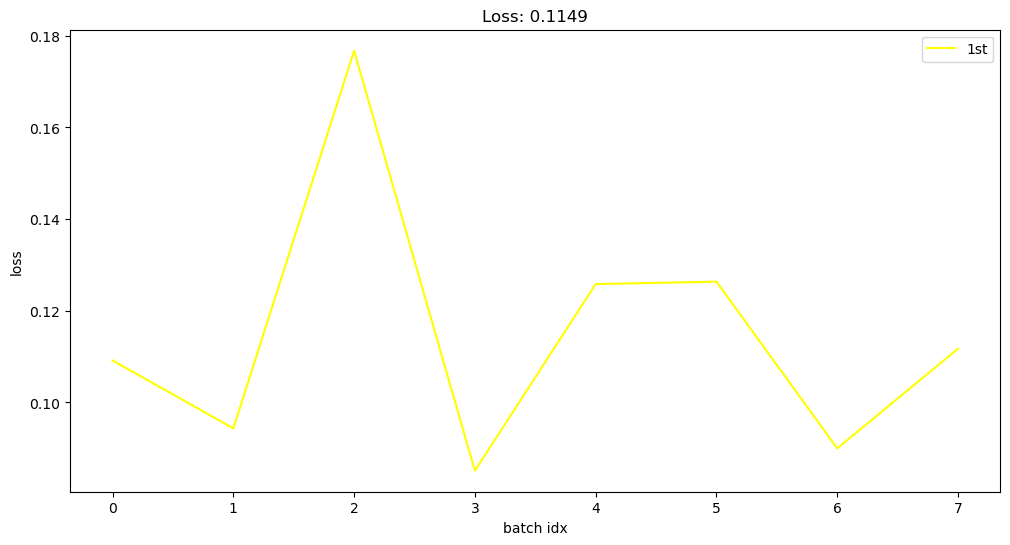

In [306]:
%matplotlib inline

# Get the Class Data
initial_dataset = TensorDataset(images_tensor, labels_tensor)
initial_loader = DataLoader(initial_dataset, batch_size=64, shuffle=True)

model.train()

losses = []
running_loss = 0.0
epoch_losses = []

for images, labels in initial_loader:
    images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)
    
    # Zero out the gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(images)

    # Calculate loss
    loss = criterion(output, labels)
    
    running_loss += loss.item()
    epoch_losses.append(loss.item())
    
losses.append(epoch_losses)

x = np.arange(len(initial_loader))
plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.title(f"Loss: {running_loss/len(initial_loader):.4f}")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

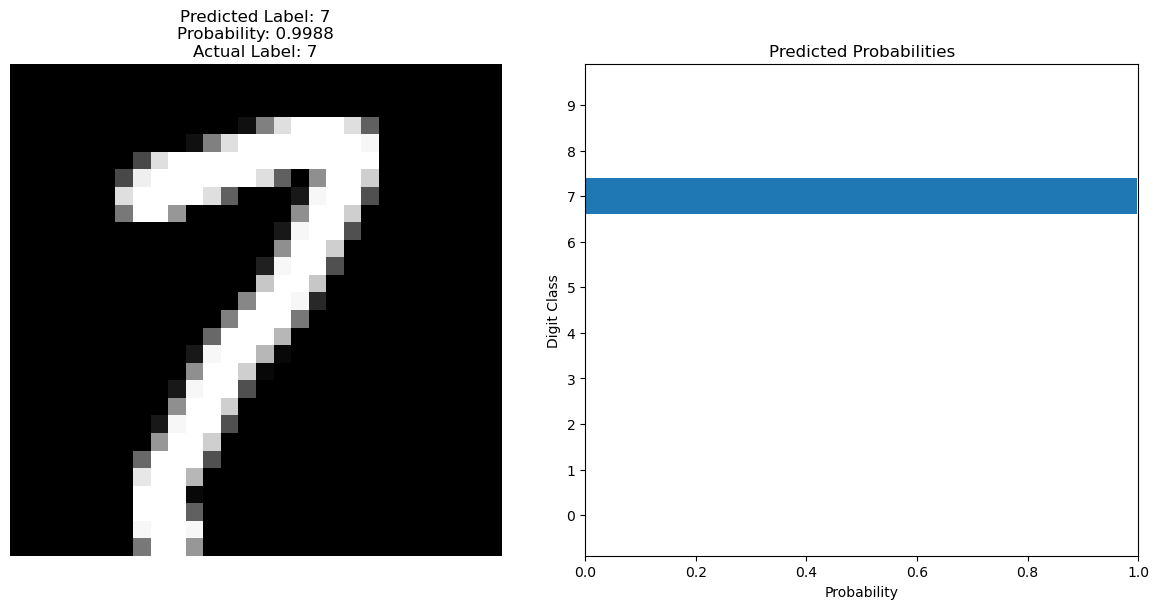

In [305]:
%matplotlib inline

from torch.utils.data import TensorDataset, DataLoader
initial_loader = DataLoader(initial_dataset, batch_size=64, shuffle=True)
model.eval()


# we are just using an image from trainloader, in the future we'll use frorm testloader
timages, tlabels = next(iter(initial_loader))

img_idx = min(4, len(images) - 1)  # Use a valid index
img = timages[img_idx].view(1, 784)  # Clamp the array within our index

# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()

# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
tlabel = class_idx.item()

# Plot the image and the probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted Label: {tlabel}\nProbability: {prob.item():.4f}\nActual Label: {tlabels[img_idx].item()}")
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlim(0, 1)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()

## Training on Class Data
And finally we'll train our model on the Class's Dataset!

Epoch 1/5, Loss: 0.2676
Epoch 2/5, Loss: 0.2241
Epoch 3/5, Loss: 0.1927
Epoch 4/5, Loss: 0.1801
Epoch 5/5, Loss: 0.1575
Training complete!

Length of loader: 8


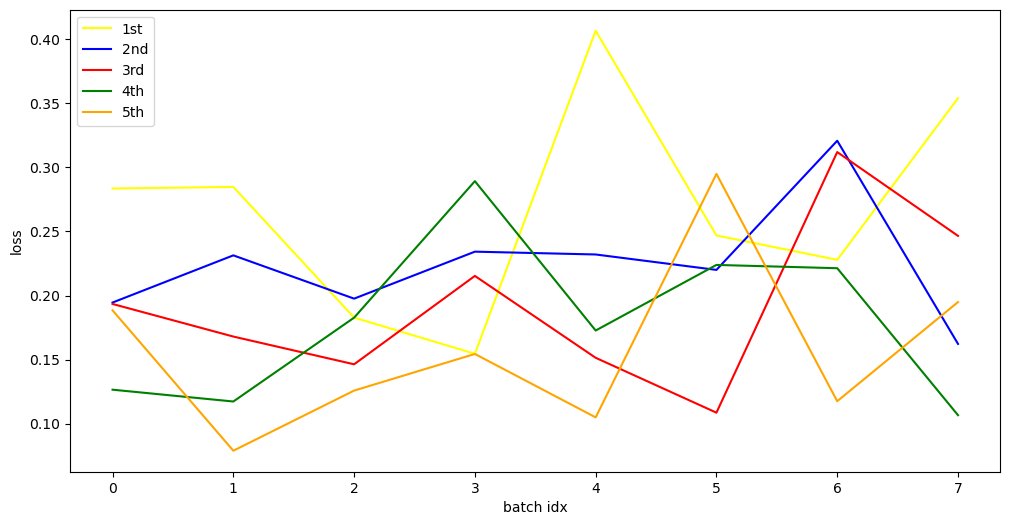

In [303]:
%matplotlib inline

# Training on the Class Data

# Get the Class Data
custom_dataset = TensorDataset(images_tensor, labels_tensor)
custom_loader = DataLoader(custom_dataset, batch_size=64, shuffle=True)

## Training Loop
losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_losses = []
    for images, labels in custom_loader:
        images = images.view(images.size(0), -1) # Flatten our images to 784 (28x28)
        
        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images)

        # Calculate loss
        loss = criterion(output, labels)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        running_loss += loss.item()
        epoch_losses.append(loss.item())

    losses.append(epoch_losses)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(custom_loader):.4f}")
    
print("Training complete!")

## Print the visuals
x = np.arange(len(custom_loader))

print (f"\nLength of loader: {len(custom_loader)}")

nplosses = np.array(losses)

plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
plt.plot(x, losses[2], color='r', label="3rd")
plt.plot(x, losses[3], color='g', label="4th")
plt.plot(x, losses[4], color='orange', label="5th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()

# Final Predictions using 580 Class Dataset
Now that our model is trained on both the MNIST dataset and the 580 Class's dataset, we can compare our previous prediction with a final prediction.

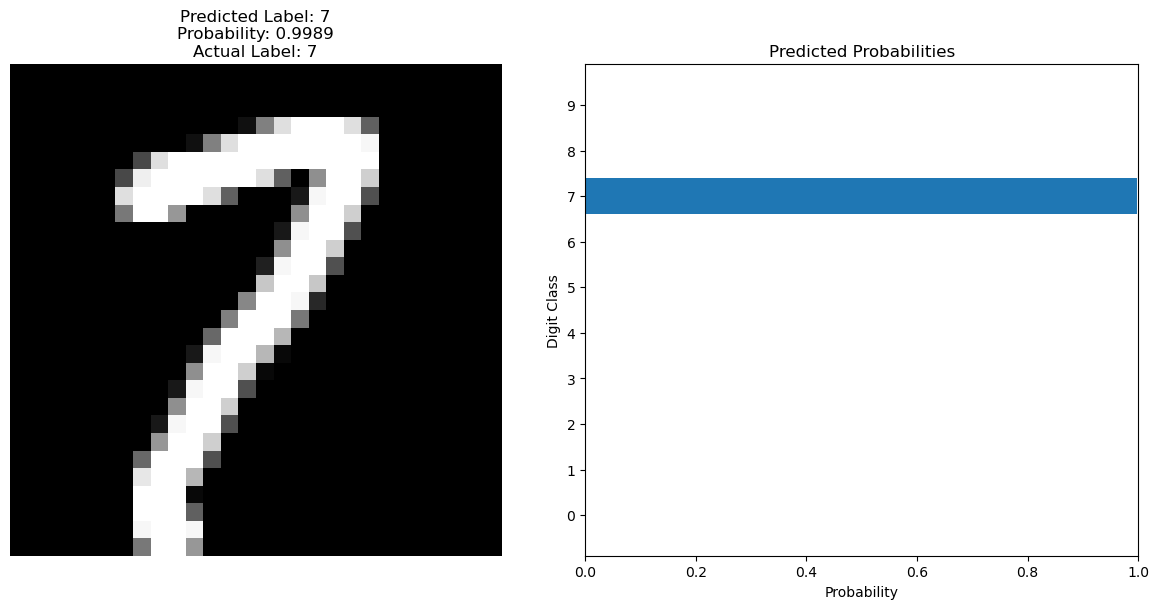

In [308]:
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader

model.eval()



img_idx = min(4, len(images) - 1)  # Use a valid index
img = timages[img_idx].view(1, 784)  # Clamp the array within our index

# Turn off gradients to speed up this part
with torch.no_grad():
    # the block of code with gradient turned off
    # here is for detection, so just do the following to compute the forward prediction.
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)

# Turn the tensor into a numpy array for visualization
img = img.view(28, 28).numpy()

# Get the predicted class
prob, class_idx = ps.topk(1, dim=1)
label = class_idx.item()

# Plot the image and the probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Plot image
ax1.imshow(img, cmap='gray')
ax1.set_title(f"Predicted Label: {tlabel}\nProbability: {prob.item():.4f}\nActual Label: {tlabels[img_idx].item()}")
ax1.axis('off')

# Plot probabilities
ax2.barh(np.arange(10), ps.squeeze().numpy())
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))  # Set y-tick labels to digits 0-9
ax2.set_xlim(0, 1)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Digit Class')
ax2.set_title('Predicted Probabilities')

plt.tight_layout()
plt.show()